# Modelos de regresión lineal

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

Hasta ahora hemos visto modelos de regresión lineal, usando inferencia exacta para la estimación de la distribución posterior de los parámetros, bajo un caso particular (suponiendo la varianza de la dispersión conocida). Si quisiéramos asumir previas distintas a la normal para los parámetros, incluyendo una previa para el parámetro de varianza, entonces la inferencia exacta de la distribución posterior se vuelve prácticamente imposible.

En este tema, estudiamos el uso de muestreo de la distribución posterior usando técnicas Montecarlo, dándonos la libertad de elegir la previa que mejor represente nuestro conocimiento de la situación.

> **Objetivos:**
> - Revisitar modelos de predicción lineal desde una perspectiva de Montecarlo.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Predicción lineal

Lo que acabamos de ver es un modelo Gaussiano para la altura de una población de adultos. Sin embargo, este modelo no tiene el componente de *regresión*.

Es común que queramos modelar como el resultado de cierta variable se relaciona con otra(s) variable(s), llamada(s) **predictor(es)**. Si el predictor tiene alguna asociación estadística con la variable de interés, la podemos usar para *predecir* dicha variable.

En este caso estudiaremos como incluir estos predictores de forma lineal en el modelo. 

Seguiremos usando los datos de los adultos en la población, pero esta vez, veremos como la altura se relaciona con el peso:

In [1]:
# Importar pandas
import pandas as pd

In [2]:
# Leer datos (separados por ;)
height_data = pd.read_csv('data/Howell1.csv', sep=';')
height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<Axes: xlabel='weight', ylabel='height'>

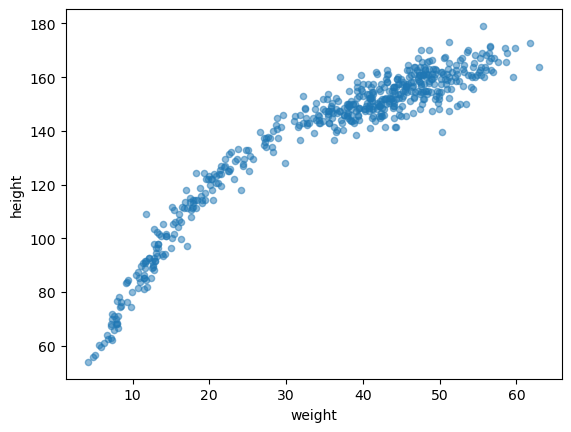

In [3]:
height_data.plot.scatter(x='weight', y='height', alpha=0.5)

<Axes: xlabel='weight', ylabel='height'>

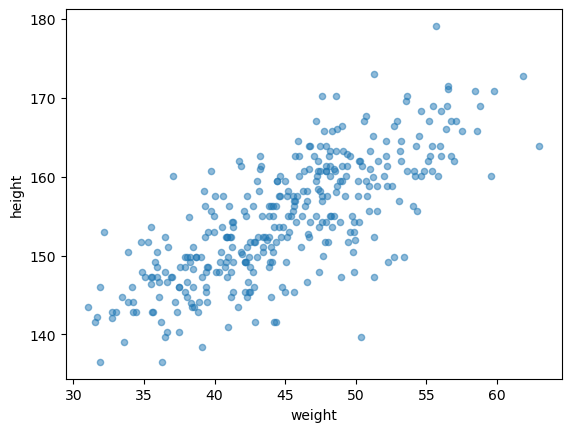

In [4]:
# Extraer datos de adultos
adult_height_data = height_data[height_data.age >= 18]
adult_height_data.plot.scatter(x='weight', y='height', alpha=0.5)

In [5]:
# Algunas filas
adult_height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [6]:
adult_height_data.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


Del gráfico anterior, observamos que en definitiva hay una relación marcada entre la altura y el peso. Es decir, conocer el peso de una persona nos ayuda a predecir su altura.

**¿Cómo adecuamos el modelo de la altura para incluir el peso como predictor?**

La estrategia es modificar el parámetro $\mu$ de la distribución Gaussiana, para que sea una función lineal del predictor. Ahora, para los parámetros de esta función, tendremos que declarar distribuciones previas.

De forma que, teníamos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

Ahora, sea $w_i$ el peso de la persona $i$ y sean $\bar{w}$ el promedio de todos los pesos. De esta forma:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Normal}(0, 10) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

*¿Qué significa esto?*

- Como antes, la primera expresión es la verosimilitud (probabilidad de los datos). Es casi la misma expresión, nada más notemos que cambiamos la media general $\mu$, por una media $\mu_i$ para cada observación. Es decir, la media depende de los valores específicos de cada observación.

- La segunda expresión, corresponde al modelo lineal. $\mu$ ya no es un parámetro que estimemos, sino una relación determinista (notar el símbolo $=$ en lugar de $\sim$) a los nuevos parámetros $\alpha$ y $\beta$, y que depende de la variable observada $w_i$.

  ¿Porqué incluir como predictor $w_i - \bar{w}$ en lugar de símplemente $w_i$? Algo importante cuando modelamos es poder entender los parámetros que estamos introduciendo. Notemos que de la manera en que especificamos el modelo $\mu=\alpha$ cuando $w_i=\bar{w}$; es decir, $\alpha$ es el valor esperado de la altura cuando el peso es promedio.

  ¿Y qué pasa con $\beta$? Bueno, pues el parámetro $\beta$ es el cambio esperado en la altura, cuando el peso cambia $1$ unidad (kg).

- Las demás expresiones, como antes, son las previas de nuestros parámetros, que deberemos ajustar con una debida simulación predictiva previa de ser necesario.

In [8]:
# Importart scipy.stats
from scipy import stats
# Importar numpy
import numpy as np

In [10]:
# Simulación previa predictiva
N = 100  # Nùmero de muestras
w = adult_height_data["weight"].values
w_bar = w.mean()
# Muestreamos distribuciones previas
alpha_samples = stats.norm.rvs(loc=170, scale=20, size=N)
beta_samples = stats.norm.rvs(loc=0, scale=10, size=N)
sigma_samples = stats.uniform.rvs(loc=0, scale=50, size=N)
# Relación lineal de la altura promedio con el peso
mu = alpha_samples + beta_samples * (w - w_bar).reshape(-1, 1)
# Muestreamos la distribución de la altura
height_samples = stats.norm.rvs(loc=mu, scale=sigma_samples)

In [15]:
from matplotlib import pyplot as plt

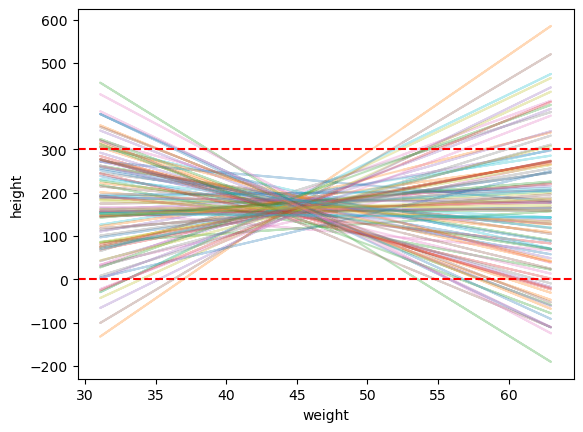

In [18]:
# Graficamos la altura promedio vs el peso
plt.plot(w, mu, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=300, color='r', linestyle='--')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

Observamos que usando estas previas, las la altura promedio puede llegar a tomar valores bastante extremos para valores normales del peso. Podemos hacer algo mejor.

De la gráfica de puntos, observamos que la relación entre la altura y el peso es positiva. Una manera común de restringir un parámetro a que sea positivo es usando la distribución $\text{Log-Normal}$. Si definimos $\beta$ como $\text{Log-Normal}(0, 1)$, significa que el logaritmo de $\beta$ tiene una distribución $\text{Normal}(0, 1)$:

$$
\beta \sim \text{Log-Normal}(0, 1)
$$

In [21]:
# Densidad lognormal
beta = stats.lognorm(s=1)

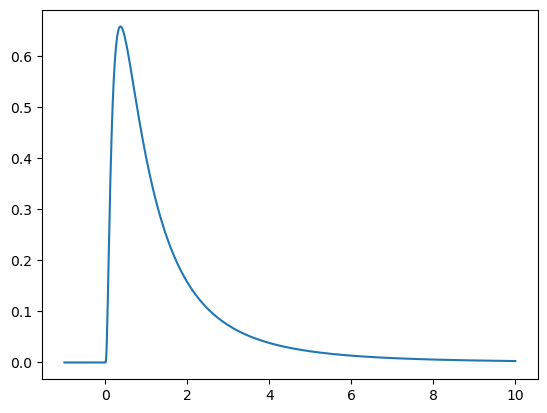

In [24]:
x = np.linspace(-1, 10, 1001)
plt.plot(x, beta.pdf(x))

In [25]:
# Simulación previa predictiva
N = 100  # Nùmero de muestras
w = adult_height_data["weight"].values
w_bar = w.mean()
# Muestreamos distribuciones previas
alpha_samples = stats.norm.rvs(loc=170, scale=20, size=N)
beta_samples = beta.rvs(size=N)
sigma_samples = stats.uniform.rvs(loc=0, scale=50, size=N)
# Relación lineal de la altura promedio con el peso
mu = alpha_samples + beta_samples * (w - w_bar).reshape(-1, 1)
# Muestreamos la distribución de la altura
height_samples = stats.norm.rvs(loc=mu, scale=sigma_samples)

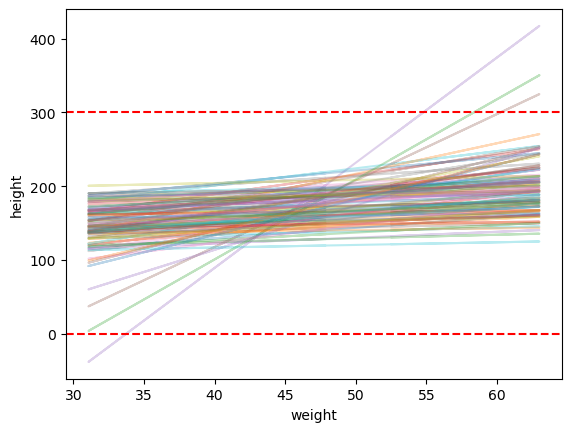

In [26]:
# Graficamos la altura promedio vs el peso
plt.plot(w, mu, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=300, color='r', linestyle='--')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

¡Esto se ve mucho mejor!

De forma que nuestro modelo completo es:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**Estimemos la distribución posterior usando MCMC:**

In [27]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az

In [63]:
# Peso
w = adult_height_data["weight"].values
# Peso promedio
w_bar = w.mean()
# Altura
h = adult_height_data["height"].values
# Modelo
with pm.Model() as linear_model_height:
    # Sigma
    sigma = pm.Uniform('sigma', 0, 50)
    # alpha y beta
    alpha = pm.Normal('alpha', mu=170, sigma=20)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    # Mu
    mu = pm.Deterministic("mu", alpha + beta * (w - w_bar))
    # Altura
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=h)
    # Muestreo
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

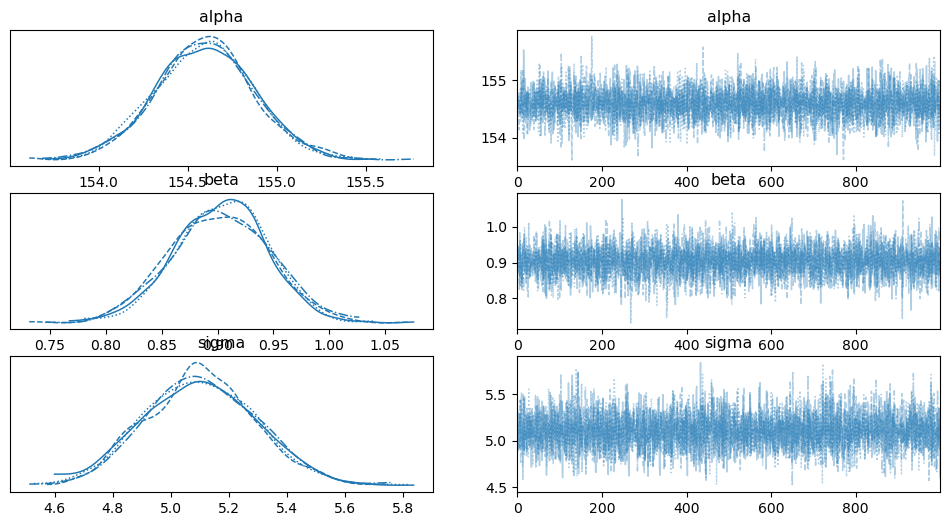

In [66]:
# Distribución posterior de los parámetros
az.plot_trace(idata, var_names=["alpha", "beta", "sigma"])

In [67]:
# az.plot_posterior
az.summary(idata, var_names=["alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.596,0.273,154.091,155.122,0.004,0.003,5825.0,2911.0,1.0
beta,0.903,0.043,0.823,0.981,0.001,0.000,6820.0,3262.0,1.0
sigma,5.104,0.193,4.763,5.485,0.002,0.002,6648.0,3380.0,1.0


¿Qué podemos decir?

- La altura promedio, al peso promedio está alrededor de 155 cm.

- Por cada 1 kg adicional, se espera que la altura sea ~0.90 cm mayor.

- El 94% de la probabilidad de la distribución posterior de $\beta$ yace entre 0.82 y 0.98, lo que indica que valores cercanos a cero y valores mayores a uno, no son compatibles con los datos y el modelo.

**Predicciones con la posterior**

La idea principal de este modelo es hacer predicciones con él. Veamos como hacerlo.

Lo primero que podríamos hacer es tomar el promedio de las muestras de $\alpha$ y $\beta$, y graficar la relación promedio:

In [68]:
# Objeto de muestreo
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [69]:
posterior_samples = idata.posterior.to_dataframe()
posterior_samples.head()

alpha     sigma      beta          mu
chain draw mu_dim_0                                            
0     0    0         154.515474  5.048997  0.943335  157.189943
           1         154.515474  5.048997  0.943335  146.492714
           2         154.515474  5.048997  0.943335  142.133593
           3         154.515474  5.048997  0.943335  162.110669
           4         154.515474  5.048997  0.943335  151.012293

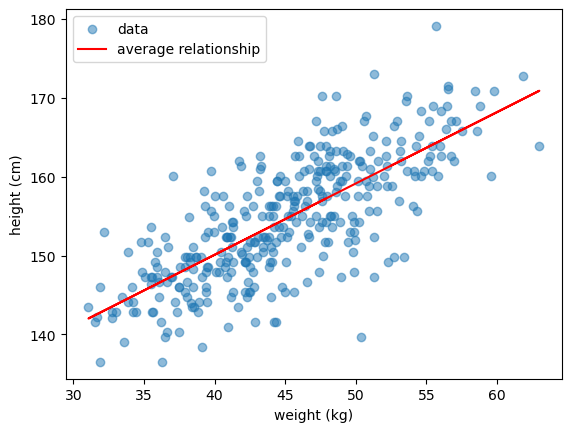

In [36]:
# Relación promedio
alpha_avg = posterior_samples['alpha'].mean()
beta_avg = posterior_samples['beta'].mean()
mu_avg = alpha_avg + beta_avg * (w - w_bar)
plt.scatter(
    adult_height_data['weight'],
    adult_height_data['height'],
    alpha=0.5,
    label='data'
)
plt.plot(w, mu_avg, color='red', label='average relationship')
plt.xlabel('weight (kg)')
plt.ylabel('height (cm)')
plt.legend()

Esta relación promedio (al tratarse el modelo de una normal) no es más que la línea promedio; la línea más plausible en el conjunto infinito de lineas en la distribución posterior.

Sin embargo, a esto le podemos añadir la incertidumbre alrededor de la media, graficando algunas líneas muestreadas de la posterior:

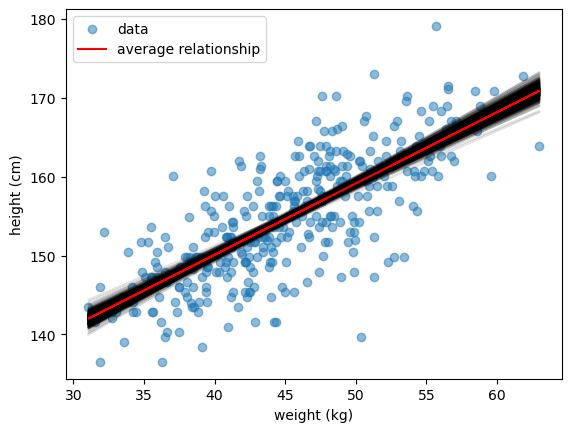

In [55]:
# Podemos sacar algunas muestras de la distribución posterior
posterior_samples_ = posterior_samples.sample(500)
post_mu = posterior_samples_['alpha'].values + posterior_samples_['beta'].values * (w - w_bar).reshape(-1, 1)
plt.scatter(
    adult_height_data['weight'],
    adult_height_data['height'],
    alpha=0.5,
    label='data'
)
plt.plot(w, post_mu, color='black', alpha=0.1)
plt.plot(w, mu_avg, color='red', label='average relationship')
plt.xlabel('weight (kg)')
plt.ylabel('height (cm)')
plt.legend()

Una pregunta que nos podríamos hacer es, ¿Cuánto es la altura promedio de una persona de 60kg?. Una vez más, podemos usar las muestras de la posterior para responder a esta pregunta:

In [57]:
# mu at 60
mu_at_60 = posterior_samples['alpha'].values + posterior_samples['beta'].values * (60 - w_bar)
mu_at_60.shape

(4000,)

<Axes: >

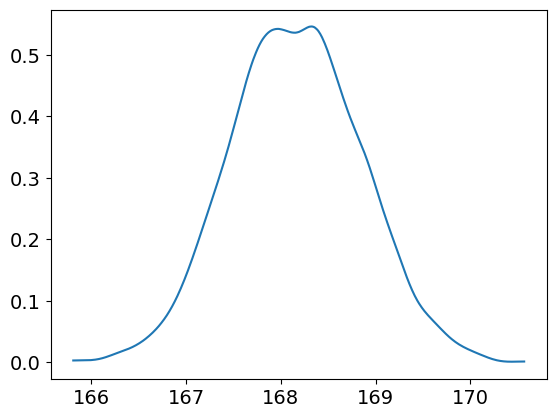

In [59]:
az.plot_kde(mu_at_60)

In [60]:
az.summary(mu_at_60)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,168.158,0.683,166.936,169.47,0.009,0.006,6152.0,3182.0,NaN


La altura promedio (89%) está entre 167 cm y 169 cm (condicional al modelo y los datos), dado que el peso es 60 kg.

**¿Y $\sigma$?**

Recordemos que el modelo de la altura era:

$$
h_i \sim \text{Normal}(\mu_i, \sigma)
$$

y aunque hasta ahora solo hemos hablado de $\mu$, la variación fuera del promedio es bastante importante.

Primero, generamos las muestras de predicción. Como antes, podríamos hacerlo a mano, pero pymc lo puede hacer por nosotros:

In [70]:
# Generamos muestras predictivas de la posterior
with linear_model_height:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [height]


In [71]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

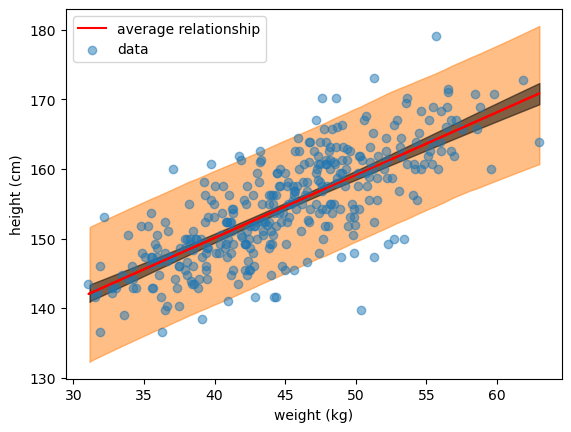

In [74]:
# Intervalo de credibilidad de la altura
az.plot_hdi(adult_height_data['weight'], idata.posterior_predictive["height"])
# Intervalo de credibilidad de la altura promedio
az.plot_hdi(adult_height_data['weight'], idata.posterior["mu"], color='black')
# Línea promedio
plt.plot(w, idata.posterior["mu"].mean(("chain", "draw")), color='red', label='average relationship')
# Nube de puntos
plt.scatter(adult_height_data['weight'], adult_height_data['height'], alpha=0.5, label='data')
plt.xlabel('weight (kg)')
plt.ylabel('height (cm)')
plt.legend()

## 2. Evaluación del modelo

Hasta ahorita usamos los mismos datos para visualizar las predicciones de nuestro modelo. ¿Cómo podemos hacer una evaluación real del modelo para fines predictivos?

In [75]:
# Separamos datos de entrenamiento y prueba
train = adult_height_data.sample(frac=0.8)
test = adult_height_data.drop(train.index)
adult_height_data.shape, train.shape, test.shape

((352, 4), (282, 4), (70, 4))

In [76]:
# Peso (entrenamiento)
w = train["weight"].values
# Peso promedio
w_bar = w.mean()
# Altura (entrenamiento)
h = train["height"].values
# Modelo
with pm.Model() as linear_model_height:
    # Peso como variable mutable
    w = pm.MutableData('w', w, dims="obs_id")
    h = pm.MutableData('h', h, dims="obs_id")
    # Sigma
    sigma = pm.Uniform('sigma', 0, 50)
    # a y b
    alpha = pm.Normal('alpha', mu=170, sigma=20)
    beta = pm.Lognormal('beta', mu=0, tau=1)
    # Mu
    mu = pm.Deterministic("mu", alpha + beta * (w - w_bar), dims="obs_id")
    # Altura
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=h, dims="obs_id")
    # Muestreo
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [78]:
# Con el modelo entrenado predecimos sobre datos de prueba
w_test = test["weight"].values
# Generamos muestras predictivas de la posterior
with linear_model_height:
    # Actualizamos valores de w
    pm.set_data({"w": w_test})
    # Muestreo de la posterior predictiva
    height_pred = pm.sample_posterior_predictive(
        idata,
        var_names=["height", "mu"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )

Sampling: [height]


c:\Users\esjim\anaconda3\envs\mgp2025_v4\lib\site-packages\pymc\backends\arviz.py:659: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  converter.nchains = idata_orig["posterior"].dims["chain"]
c:\Users\esjim\anaconda3\envs\mgp2025_v4\lib\site-packages\pymc\backends\arviz.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  converter.ndraws = idata_orig["posterior"].dims["draw"]


In [79]:
# Atributo predictions
height_pred

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

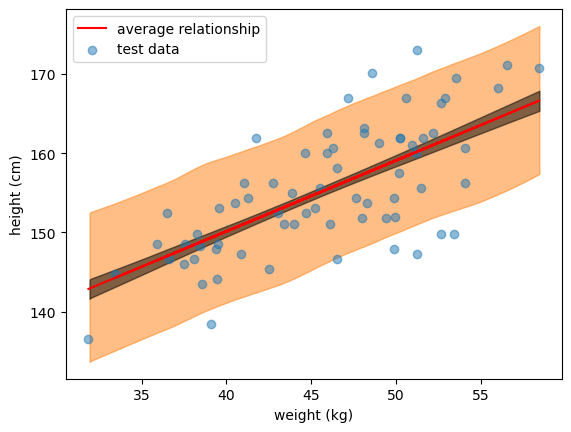

In [82]:
# Intervalo de credibilidad de la altura
az.plot_hdi(test['weight'], height_pred.predictions["height"])
# Intervalo de credibilidad de la altura promedio
az.plot_hdi(test['weight'], height_pred.predictions["mu"], color='black')
# Línea promedio
plt.plot(test["weight"], height_pred.predictions["mu"].mean(("chain", "draw")), color='red', label='average relationship')
# Nube de puntos
plt.scatter(test['weight'], test['height'], alpha=0.5, label='test data')
plt.xlabel('weight (kg)')
plt.ylabel('height (cm)')
plt.legend()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

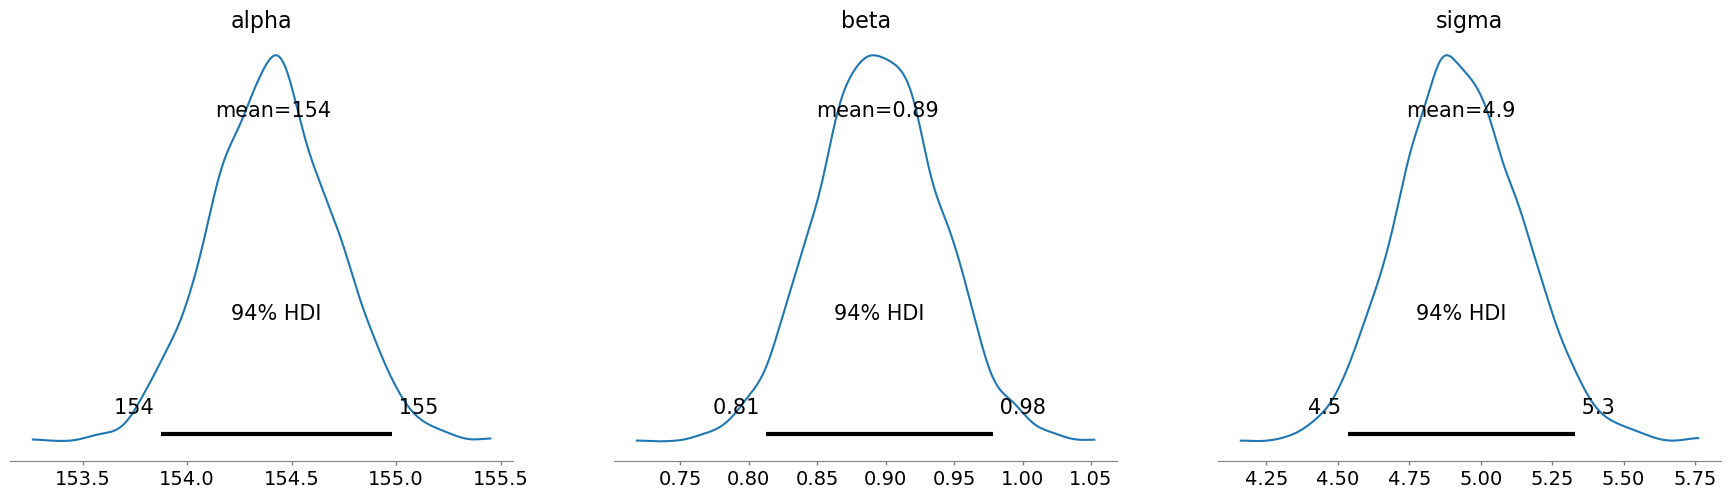

In [84]:
az.plot_posterior(idata, var_names=["alpha", "beta", "sigma"])

In [83]:
# Importamos sklearn.metrics.r2_score, mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error

In [85]:
# R2
r2_score(test['height'], height_pred.predictions["mu"].mean(("chain", "draw")))

0.4940184084706706

In [87]:
# MSE
mean_squared_error(test['height'], height_pred.predictions["mu"].mean(("chain", "draw")))

33.18457641328577

In [95]:
# % entre lower y upper de hdi
lower, higher = np.array(az.hdi(height_pred.predictions["height"])["height"]).T
((lower <= test['height']) & (test['height'] <= higher)).mean()

0.8571428571428571

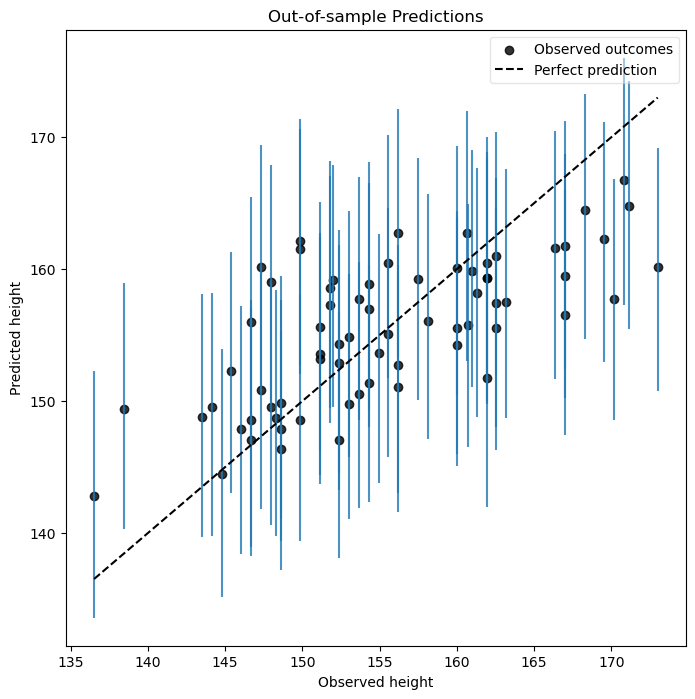

In [97]:
# Gráfica posterior predictiva para problemas de regresión
_, ax = plt.subplots(figsize=(8, 8))

model_preds = height_pred.predictions

# uncertainty about the estimates:
ax.vlines(
    test["height"].values,
    *az.hdi(model_preds)["height"].transpose("hdi", ...),
    alpha=0.8,
)

# actual outcomes:
ax.scatter(
    x=test["height"].values,
    y=model_preds["height"].mean(("chain", "draw")),
    marker="o",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)

x_min = test["height"].min()
x_max = test["height"].max()
ax.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="k", label="Perfect prediction")
ax.set_xlabel("Observed height")
ax.set_ylabel("Predicted height")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

La anterior gráfica fue adaptada de: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html

## 3. Comentarios finales

Como en la clase 3, podemos usar este mismo tipo de modelos lineales en los parámetros para representar relaciones no lineales entre los datos. Podemos usar polinomios, o cualquier otro tipo de representaciones no lineales que nos interese.

Por ejemplo, si consideraramos todos los datos, incluyendo los de los niños:

Text(0, 0.5, 'Height (cm)')

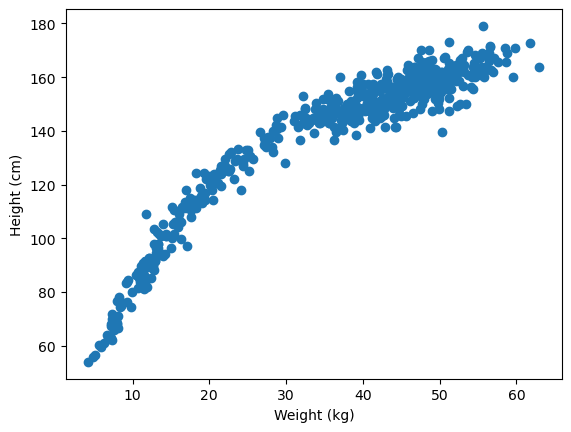

In [98]:
# Scatter plot
plt.scatter(height_data["weight"], height_data["height"])
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")

Observamos una relación cúbica. **Tarea**

**Ayuda**. Estandarizar el peso antes.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>